# NSB with contours

This notebook contains the essentisla to plot the night sky brighntess from an image.
The beginning of this notenook will contain the essential librarires an input data needed.
The aim is to clearly show how to do it and avoid exploratory code.

## Python libraries

In [1]:
# -------------------------
# Standard Python libraries
# -------------------------

import os
from fractions import Fraction

# ---------------------
# Third party libraries
# ---------------------
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

import exifread
import numpy as np
import numpy.ma as ma
import astropy.units as u
from astropy.io import fits

from astropy.table import Table
from scipy.ndimage import gaussian_filter

## Auxiliar functions

In [2]:
def nixnox_colormap(split_level: int =192) -> LinearSegmentedColormap:
    """make a 256 point combined colormap from reversed viridis and YlOrRd"""
    assert 0 < split_level < 256
    colors2 = plt.cm.viridis_r(np.linspace(0, 1, split_level))
    colors1 = plt.cm.YlOrRd_r(np.linspace(0, 1, 256 - split_level))
    colors = np.vstack((colors1, colors2))
    return mcolors.LinearSegmentedColormap.from_list("nixnos_cmap", colors)

def plot_magnitudes(image, nixnox, min_mag=20, max_mag=22, xmin=450, xmax=2650, fsize=14):
    fig, ax = plt.subplots(ncols=1,figsize=(8,6),dpi=150)
    im = ax.imshow(image,cmap=nixnox, vmin=min_mag, vmax=max_mag)
    ax.set_xlabel('u [pixel]',fontdict={'size':fsize})
    ax.set_ylabel('v [pixel]',fontdict={'size':fsize})
    cbar = fig.colorbar(im, shrink=0.99, ax=ax)
    cbar.set_label('G Brightness [mag/arcsec$^2$]',fontdict={'size':fsize}) 
    cbar.ax.tick_params(labelsize=14)
    plt.xticks(size=fsize)
    plt.yticks(size=fsize)
    plt.xlim(xmin,xmax)

def plot_contours(image, cmap, min_mag=20, max_mag=22, xmin=450, xmax=2650, fsize=14):
    nticks=6
    cb_ticks = np.round(np.linspace(min_mag, max_mag, num=nticks, endpoint=True), 1)
    fig, ax = plt.subplots(ncols=1,figsize=(8,6),dpi=150)
    #im = ax.imshow(NSB_filt,cmap=nixnox, vmin=20, vmax=22)
    ax.set_xlabel('u [pixel]',fontdict={'size':fsize})
    ax.set_ylabel('v [pixel]',fontdict={'size':fsize})
    cax = ax.contour(image,
                cmap=cmap,
                vmin=min_mag,
                vmax=max_mag,
                levels=[20,20.5,21,21.5,22],
                linewidths=2
    )
    ax.clabel(cax,colors="k",inline=True,fmt="%1.1f",rightside_up=True,fontsize="medium")
    cb = fig.colorbar(cax, orientation="vertical", shrink=0.99, ticks=cb_ticks, pad=0.08)
    cb.set_label("Sky Brightness [mag/arcsec$^2$]", fontsize=fsize)
    cb.ax.tick_params(labelsize=12)
    plt.xticks(size=fsize)
    plt.yticks(size=fsize)
    plt.xlim(450,2650)

## Input data and constants

### Input Path
The sample image - made by Rémi Boucher - was located in Pic du Midi Observatory (France). 
This is a RAW format image.

In [3]:
SAMPLE_IMAGE = 'IMG_9467.CR2'
ipath   = os.path.join(os.getcwd(), "images", "remi")
ifile = os.path.join(ipath, SAMPLE_IMAGE) 

### Escale factor area in pixels to area in arcsec2
For the current image, the plate are scale in ${arsec}^2$ is

In [4]:
DOMEGA = 57758.36824261549

### Zero points

From the photometry notebook, we have determined the following photemtry zero points per channel

In [5]:
ZP_B = 10.93
ZP_G = 11.11
ZP_R = 10.0

### Exposure time
We obtaion the exposure time in seconds from the EXIF metadata in the original image

In [6]:
with open(ifile, 'rb') as f:
    exif_tags = exifread.process_file(f)
T_EXPO = float(Fraction(str(exif_tags.get('EXIF ExposureTime'))))

### Input Pixels
We already have the `IMG_9467_G2_corr.fits` vigneting corrected FITS file

In [7]:
filename = ifile.replace('.CR2','_G2_corr.fits')
G2_PIX  = fits.getdata(filename)
G2_PIX = ma.masked_array(G2_PIX, mask=[G2_PIX == 0])

### Night Sky Brightness map
Since we have the exposure time `T_EXPO`, the pixel values in DN `G2_PIX`, the zero point corresponding to the desired channel `ZP_G` and the pixel area scale `DOMEGA`, we can transfrom the image from its brighnets value in DN to a magnitude scale in $mag/{arcsec}²$ 

The quick here resides of the corrected image, whose pixels out of the fisheye lens have been set to zero. This poses a problem when computing magnitudes. The solution is to use a masked array and perform a masked ${log}_{10}$ function.

In [8]:
NSB = ZP_G - 2.5*np.ma.log10(G2_PIX/(DOMEGA*T_EXPO))

## Plotting the Night Sky Brightness map

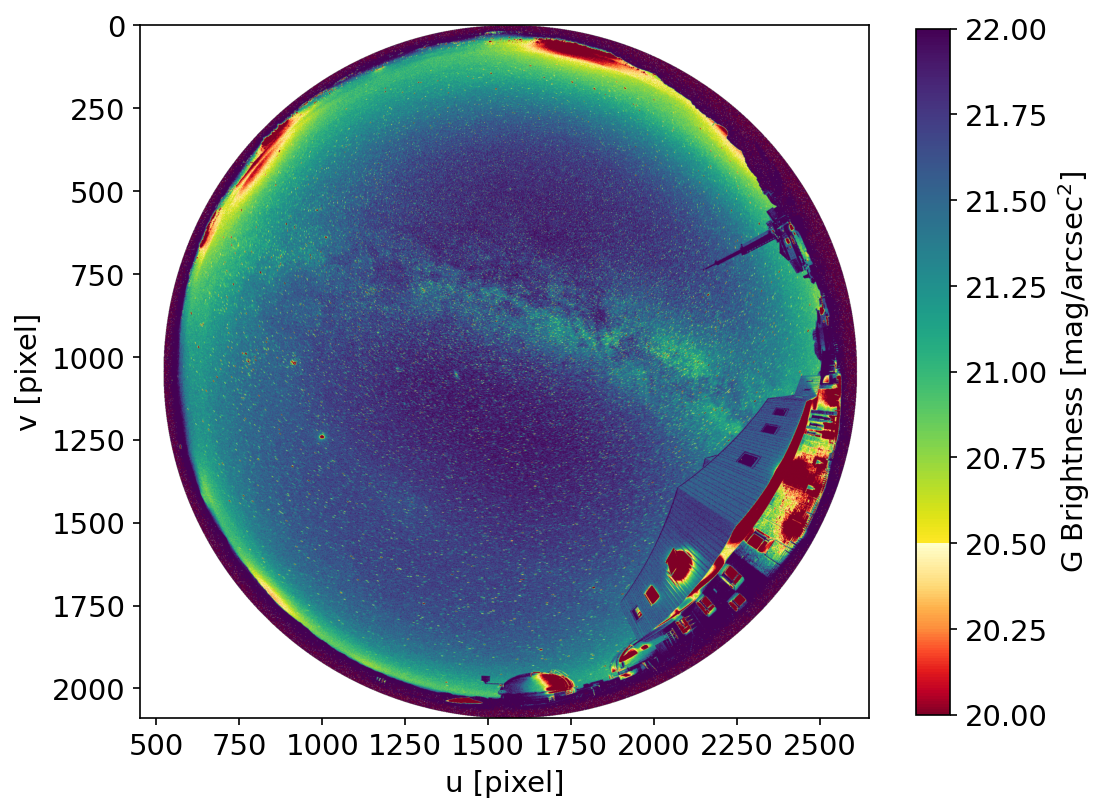

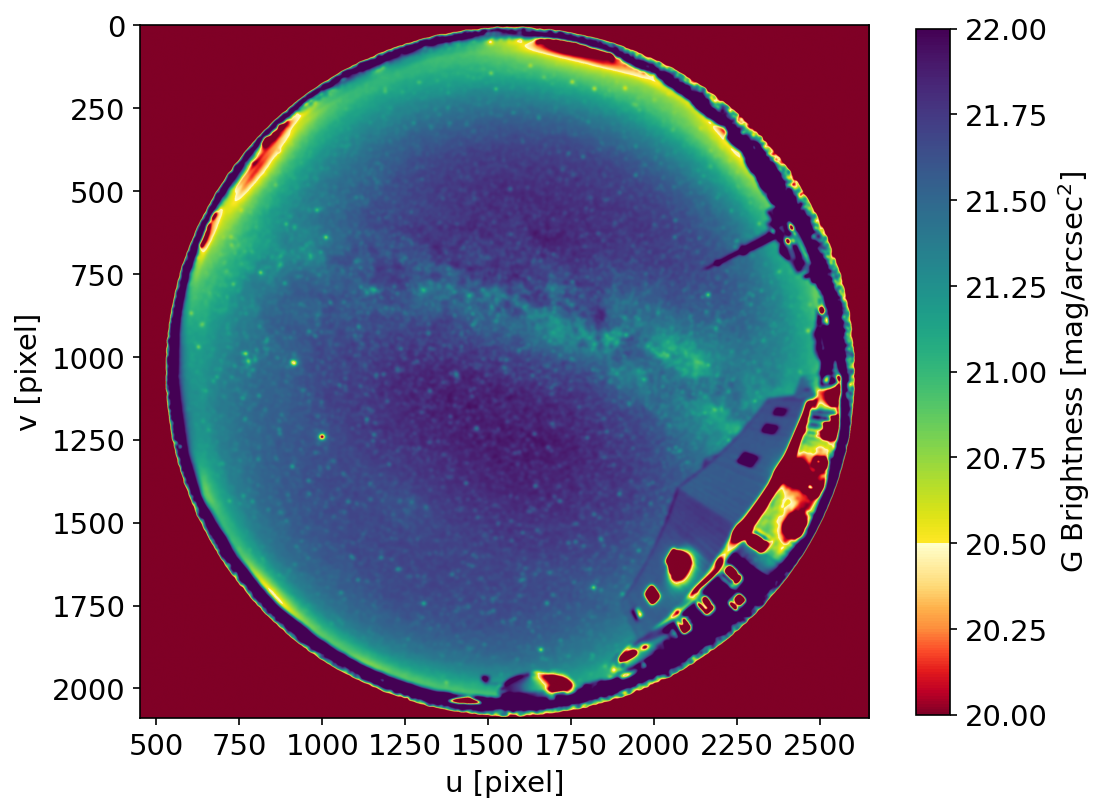

In [9]:
nixnox = nixnox_colormap()
NSB_filt = gaussian_filter(NSB, sigma=5,  radius=500, mode="constant", cval=16)
plot_magnitudes(NSB, nixnox)
plot_magnitudes(NSB_filt,nixnox)

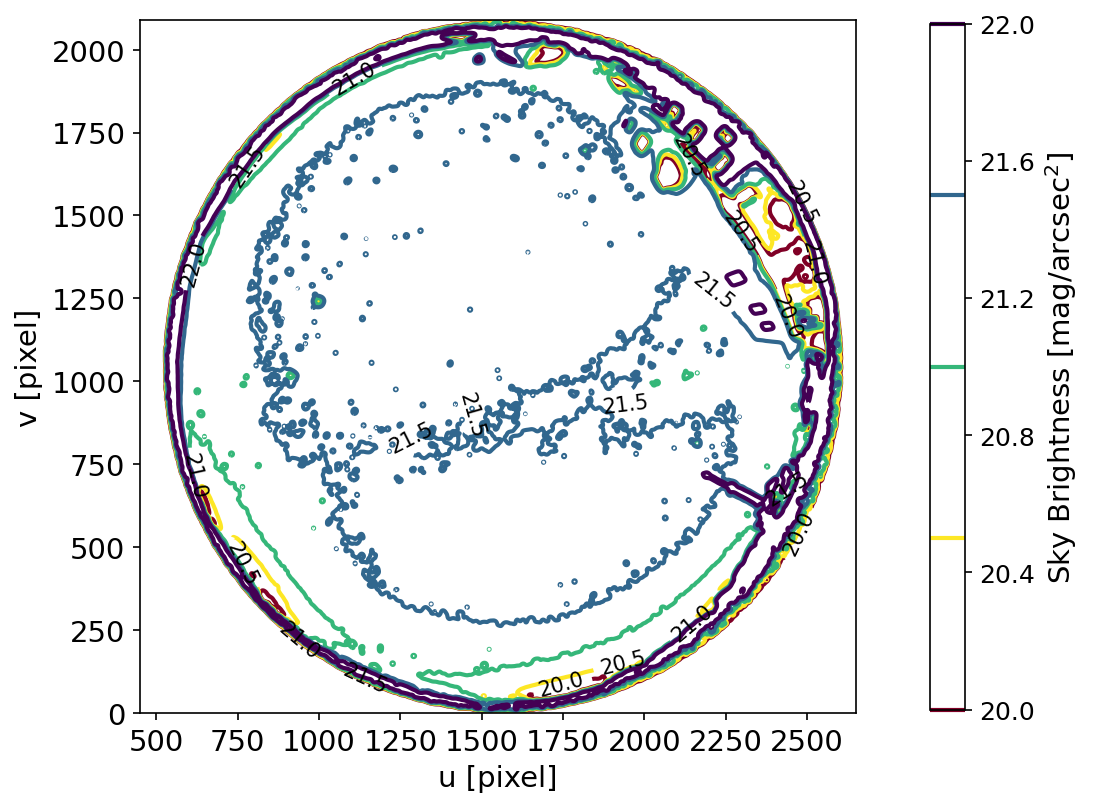

In [11]:
plot_contours(NSB_filt, nixnox)
